In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from features import *
import matplotlib.pyplot as plt
import librosa
import librosa.display
import gc

In [32]:
TEST_SIZE = 0.4
RANDOM_SEED = 191

SAMPLE_RATE = 44100 / 3

N_FFT = 2048
HOP_LENGTH = 512
N_MEL_BINS = 128
N_MFCC = 24

WINDOW = 'blackmanharris'

LEARNING_RATE = 1e-3
BATCH_SIZE = 64

In [4]:
from prepare_data import sample_train_test_songs, form_audio_data_array

train_songs, val_songs, test_songs = sample_train_test_songs(test_size=TEST_SIZE, random_seed=RANDOM_SEED, include_val=True)
print(f'Train: {len(train_songs)} songs')
print(f'Val: {len(val_songs)} songs')
print(f'Test: {len(test_songs)} songs')

Train: 35 songs
Val: 5 songs
Test: 5 songs


In [33]:
X_train, Y_train = form_audio_data_array(song_names=train_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
                                         hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC)
X_val, Y_val = form_audio_data_array(song_names=val_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
                                     hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

Jin Suga J-Hope RM Jimin V Jungkook 
Jin Suga J-Hope RM Jimin V Jungkook 
(971, 24, 290) (971,)
(126, 24, 290) (126,)


In [34]:
np.save(f'tmp/X_train_{RANDOM_SEED}_{N_MFCC}.npy', X_train)
np.save(f'tmp/Y_train_{RANDOM_SEED}_{N_MFCC}.npy', Y_train)
np.save(f'tmp/X_val_{RANDOM_SEED}_{N_MFCC}.npy', X_val)
np.save(f'tmp/Y_val_{RANDOM_SEED}_{N_MFCC}.npy', Y_val)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2 as L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
gc.collect()

18126

In [36]:
model = tf.keras.Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=512, activation='relu', kernel_regularizer=L2(l=0.01)),
    Dense(units=256, activation='relu', kernel_regularizer=L2(l=0.01)),
    Dense(units=128, activation='relu', kernel_regularizer=L2(l=0.01)),
    Dense(units=7, activation='softmax')
])

optimiser = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE, epochs=100, callbacks=[early_stopping])

Train on 971 samples, validate on 126 samples
Epoch 1/100
971/971 [==============================] - 1s 903us/sample - loss: 242.3810 - accuracy: 0.1555 - val_loss: 247.9570 - val_accuracy: 0.0794
Epoch 2/100
971/971 [==============================] - 0s 214us/sample - loss: 93.0074 - accuracy: 0.2327 - val_loss: 50.2449 - val_accuracy: 0.1984
Epoch 3/100
971/971 [==============================] - 0s 204us/sample - loss: 28.9461 - accuracy: 0.3893 - val_loss: 37.8312 - val_accuracy: 0.1746
Epoch 4/100
971/971 [==============================] - 0s 224us/sample - loss: 17.5517 - accuracy: 0.5201 - val_loss: 20.7137 - val_accuracy: 0.3175
Epoch 5/100
971/971 [==============================] - 0s 225us/sample - loss: 12.5312 - accuracy: 0.6189 - val_loss: 24.9104 - val_accuracy: 0.1984
Epoch 6/100
971/971 [==============================] - 0s 203us/sample - loss: 12.4745 - accuracy: 0.6159 - val_loss: 16.7275 - val_accuracy: 0.2619
Epoch 7/100
971/971 [==============================] - 0s 

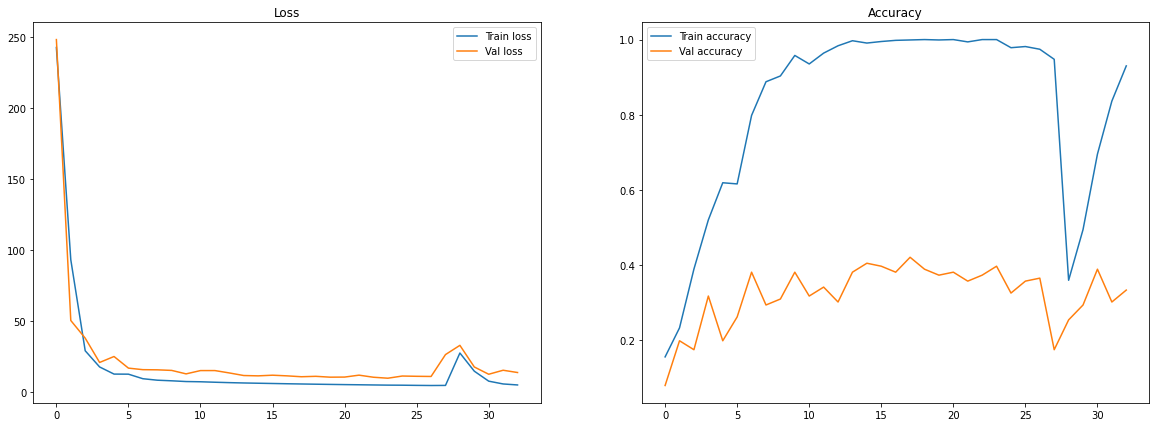

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(history.history['loss'], label='Train loss')
ax[0].plot(history.history['val_loss'], label='Val loss')
ax[1].plot(history.history['accuracy'], label='Train accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].legend()
ax[1].legend()

In [39]:
model.evaluate(X_val, Y_val)

126/126 [==============================] - 0s 216us/sample - loss: 10.6667 - accuracy: 0.4206


[10.666747895498125, 0.42063493]